<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Web APIs & NLP on Internet and Alcohol Addiction Subreddits <br> [Part 2 of 2]

_Prepared by: Timothy Chan, 17 Mar 2023_

## Contents:
- [Data Cleaning](#Data-Cleaning)
- [Preprocessing](#Preprocessing)
- [EDA](#EDA)
- [Modelling](#Modelling)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

**Part 2** consists of Data Cleaning, Preprocessing, EDA, Modelling and Recommendations. 

We will perform preprocessing to remove stopwords and useless phrases, tokenize and lemmantize to prepare for modelling. We will then perform exploratory data analysis (EDA) to understand the frequent words within each dataset and to see if cleaning and preprocessing is sufficient.

Subsequently, we will compare 8 models using 2 different vectorizers (Count Vectorizer and TF-IDF Vectorizer) and 4 classifier techniques (Linear models: Logistic Regression and Multinomial Naive Bayes; Ensemble models: Random Forest and Gradient Boosting).

Performance will be evaluated on accuracy.

For Data Collection, please refer to **Part 1**.

### Data Dictionary

Data dictionary (cleaned).

|Features|Type|Description|
|:---|:---|:---|
|subreddit|integer|subreddit in which data is extracted from|
|text|string|combination of title and subject of each subreddit post|
|text_cleaned|string|cleaned and preprocessed text|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import textwrap

In [2]:
df_nosurf = pd.read_csv("data/data_nosurf.csv")
df_stopdrinking = pd.read_csv("data/data_stopdrinking.csv")

---
## Data Cleaning
---

In [3]:
# Concat both dataframes
df = pd.concat([df_nosurf, df_stopdrinking], axis=0)
len(df)

2000

In [4]:
# Set nosurf as 1 and stopdrinking as 0
df['subreddit'] = df['subreddit'].apply(lambda x: 1 if x == 'nosurf' else 0 if x == 'stopdrinking' else x)

df["subreddit"].value_counts()

1    1000
0    1000
Name: subreddit, dtype: int64

In [5]:
# Replace [removed] and [deleted] in selftext column with blank
df["selftext"] = df["selftext"].apply(lambda x: "" if pd.isna(x) or x in ["[removed]", "[deleted]"] else x)

In [6]:
# Create temporary DataFrame for those with no blank text
df_temp_1 = df[df['selftext'] != ""]
df_temp_1['selftext'].duplicated().sum()

3

In [7]:
# Remove duplicates for those which are not blank text
df_temp_1 = df_temp_1.drop_duplicates(subset=['selftext'])

In [8]:
# Create temporary DataFrame for blank text
df_temp_2 = df[df['selftext'] == ""]
len(df_temp_2)

108

In [9]:
# Merge deduped temporary DataFrame (non blank text) with blank text 
df = pd.concat([df_temp_1, df_temp_2], axis=0)
len(df)

1997

In [10]:
# Combine title and content
df["text"] = df["title"] + " " + df["selftext"]

# Keep only necessary columns
df = df[["subreddit", "text"]]

In [11]:
# Check for null values
df.isnull().sum()

subreddit    0
text         1
dtype: int64

In [12]:
# Drop null and blank values
df.dropna(inplace=True)
df = df[df['text'] != ""]

In [13]:
# Check how many remaining rows for each subreddit
df["subreddit"].value_counts()

1    998
0    998
Name: subreddit, dtype: int64

In this binary classification problem, we have set `r/nosurf` to be 1 and `r/stopdrinking` to be 0.

The title and content was combined to form the text to be analysed. On reddit, the original poster may choose to write everything in the title itself, with little or no content. By combining both title and content, it captures the essence of the post.

As intended, both subreddits are quite balanced by number of documents (rows) within the corpus. After data cleaning, there is sufficient data to proceed with the modelling.

---
## Preprocessing
---

The following preprocessing steps will be applied to process the text before modelling:
1. Lowercase all text
2. Remove websites, links and special characters which are not useful for the model
3. Remove obvious two-words phrases before tokenizing by words
4. Tokenize by words
5. Remove stop words using both NLTK and CountVectorizer's stop word dictionaries. This is to ensure that more of the unnecessary or meaningless words are removed. Such words would appear in the top 30 frequent phrases in EDA process if both sets of stop words were not removed.
6. Also remove obvious one-word phrases
7. Lemmatize. This technique to normalize words produces more accurate and meaningful base word than stemming.
8. Convert to string

Obvious word phrases *directly* related to one category are removed for purpose of this project. These words do not need to be trained using machine learning. Obvious words include:
- topics: alcohol, drink/drinking, internet, social media
- subreddit names: nosurf and stopdrinking

In [14]:
# Function to preprocess text
def preprocess_text(text):
    # All text in lowercase
    text = text.lower()
    
    # Remove links with "https:"
    text = re.sub(r'https:\S+', '', text) # https: followed by non-whitespace characters

    # Remove websites starting with "www" and ending with "com"
    text = re.sub(r'\bwww\.\S+\.com\b', '', text)
    
    # Remove HTML entity (special characters) &amp;#x200B;
    text = re.sub(r'&amp;#x200b;', '', text)
    
    # Remove obvious word phrases: "social media" as a single phrase before tokenizing
    text = re.sub(r'social media', '', text)    
    
    # Tokenize by words using a RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Remove stop words using NLTK's and CVEC's English stop words, and manually listed obvious stop words
    stop_words_nltk = set(stopwords.words('english'))
    stop_words_cvec = set(CountVectorizer(stop_words='english').get_stop_words())
    stop_words_manual = set({'alcohol', 'drinking', 'drink', 'internet', 'nosurf', 'stopdrinking'})
    stop_words = set.union(stop_words_nltk, stop_words_cvec, stop_words_manual)
    tokens = [token for token in tokens if token not in stop_words]
           
    # Lemmatize the tokens using a WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens into a single string using a space delimiter
    text = ' '.join(tokens)
    
    return text

In [15]:
# Apply preprocessing to new column
df['text_cleaned'] = df['text'].apply(preprocess_text)

# Reset index
df = df.reset_index(drop=True)

In [16]:
# Quick comparison of original and processed text
df.head()

,subreddit,text,text_cleaned
0,1,How to stop using the Internet as a coping mec...,stop using coping mechanism basically bad habi...
1,1,The more time I spend away from YouTube and ot...,time spend away youtube boring content blocker...
2,1,Save your memories in a safe space that won't ...,save memory safe space make addicted lose time...
3,1,2020 vs 2023 me Damn how much I've improved is...,2020 v 2023 damn improved astounding 2020 vers...
4,1,Found a solution for sleep procrastination Fin...,solution sleep procrastination tv screen bed w...


In [17]:
# Split by subreddit
df_internet = df[df['subreddit'] == 1]
df_alcohol = df[df['subreddit'] == 0]

# Define text
internet_text = df_internet['text_cleaned']
alcohol_text = df_alcohol['text_cleaned']

---
## EDA
---

**Sentiment Analysis**

In [18]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a function to perform sentiment analysis on a piece of text; get a sentiment score for the text
def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)

    # Return the compound score
    return sentiment['compound']

In [19]:
# Print results for cleaned text
print(f"r/nosurf | Sentiment compound score: {round(df_internet['text_cleaned'].apply(analyze_sentiment).mean(),3)}")
print(f"r/stopdrinking | Sentiment compound score: {round(df_alcohol['text_cleaned'].apply(analyze_sentiment).mean(),3)}")

r/nosurf | Sentiment compound score: 0.257
r/stopdrinking | Sentiment compound score: 0.248


The sentiments of each subreddit's cleaned text are scored using the NLTK SentimentIntensityAnalyzer. This is to consider if sentiments should part of the classification model, and also it is helpful to understand each subreddit and topic better.

Both addiction subreddits have a moderately positive compound score, with Internet addiction subreddit being slightly more positive. Since there is little difference between both scores, the phrases will not be classified based on sentiments.

Despite addiction being a negative topic in general, these could be moderately positive because posters on the subreddit are more likely to have intentions of changing their negative habits, and also there could be encouraging posts by the online community.

`r/nosurf` could be slightly more positive than `r/stopdrinking` due to the stronger social and emotional impact of alcohol compared to internet addiction.

Note that these are analysed on processed words and will not include word expressions in original text e.g. full-capitalized words or exclamation marks.

**Top Word Frequency**

In [20]:
# Function to plot bargraph of most frequent words or phrases for each subreddit
def top_n_words(corpus1, corpus2, name1, name2, ngram_n, n_words):
    # Initialize CountVectorizer
    cv1 = CountVectorizer(stop_words=None,ngram_range=(ngram_n, ngram_n))
    cv2 = CountVectorizer(stop_words=None,ngram_range=(ngram_n, ngram_n))
    
    # Fit and Transform
    status_cv1 = cv1.fit_transform(corpus1)
    status_cv2 = cv2.fit_transform(corpus2)

    # Get feature names and convert to DataFrame
    status_df1 = pd.DataFrame(status_cv1.todense(), columns=cv1.get_feature_names_out())
    status_df2 = pd.DataFrame(status_cv2.todense(), columns=cv2.get_feature_names_out())

    # Plot top n words as bar chart
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    status_df1.sum().sort_values(ascending=False).head(n_words)[::-1].plot(kind='barh', color='seagreen', ax=axs[0])
    axs[0].set_title(f"Top {n_words} Most Common Words in {name1}")
    axs[0].set_xlabel("Frequency")
    
    status_df2.sum().sort_values(ascending=False).head(n_words)[::-1].plot(kind='barh', color='steelblue', ax=axs[1])
    axs[1].set_title(f"Top {n_words} Most Common Words in {name2}")
    axs[1].set_xlabel("Frequency")
    
    plt.tight_layout()

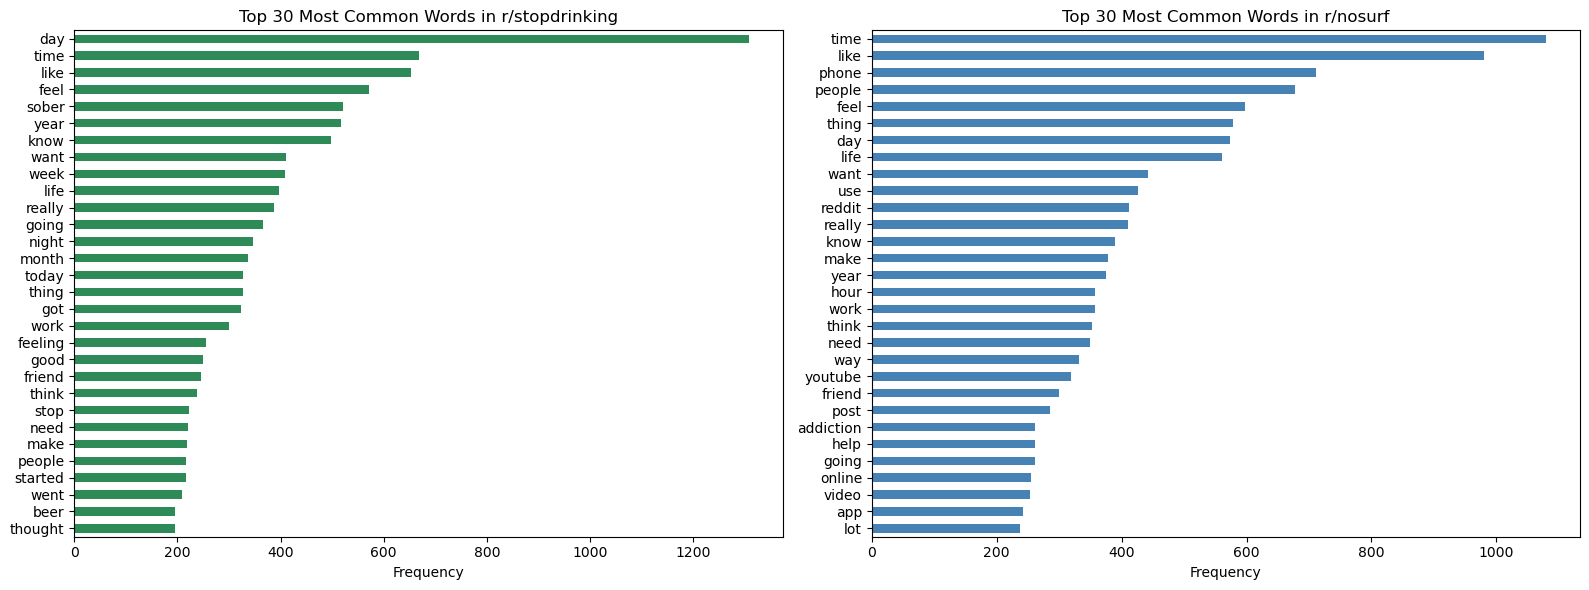

In [21]:
top_n_words(alcohol_text, internet_text, 'r/stopdrinking', 'r/nosurf', 1, 30)

Analysis of top one-word phrases:
- The Internet addiction list contains tools or platforms which are subject of addiction (e.g. phone, reddit, youtube). The Alcohol addiction list only contain one such subjects (beer). There are more variety of addiction subjects for the Internet.
- Time related words ('time', 'day', 'life', 'year' etc) are frequent words on both subreddits. Regret about time spent on bad habits or addictions, or having more time to do other things being a motivation for change could be topics of posts. 
- The word 'work' appears frequently in both. Both addictions could possibly cause disruption to work
- Emotions could be a part of habits or addictions. The word 'feel' appears frequently in both subreddits
- Community could be important in habit or addiction change. Words like 'friend' and 'people' appear in both.

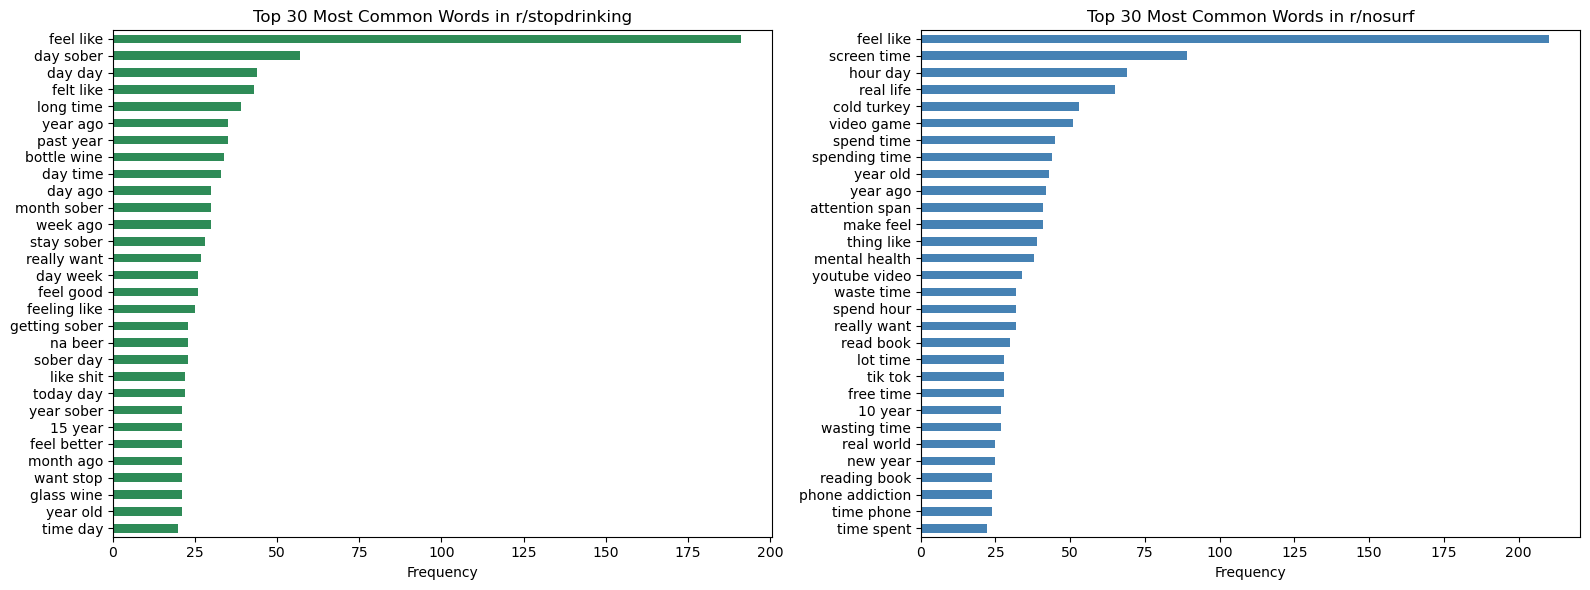

In [22]:
top_n_words(alcohol_text, internet_text, 'r/stopdrinking', 'r/nosurf', 2, 30)

Analysis of top two-word phrases:
- The phase 'feel like' is the most frequent word on both subreddits. Emotions could be a big part of habit or addiction changing.
- Reading books is seen as an alternative to using the internet.
- Time is again a frequent topic

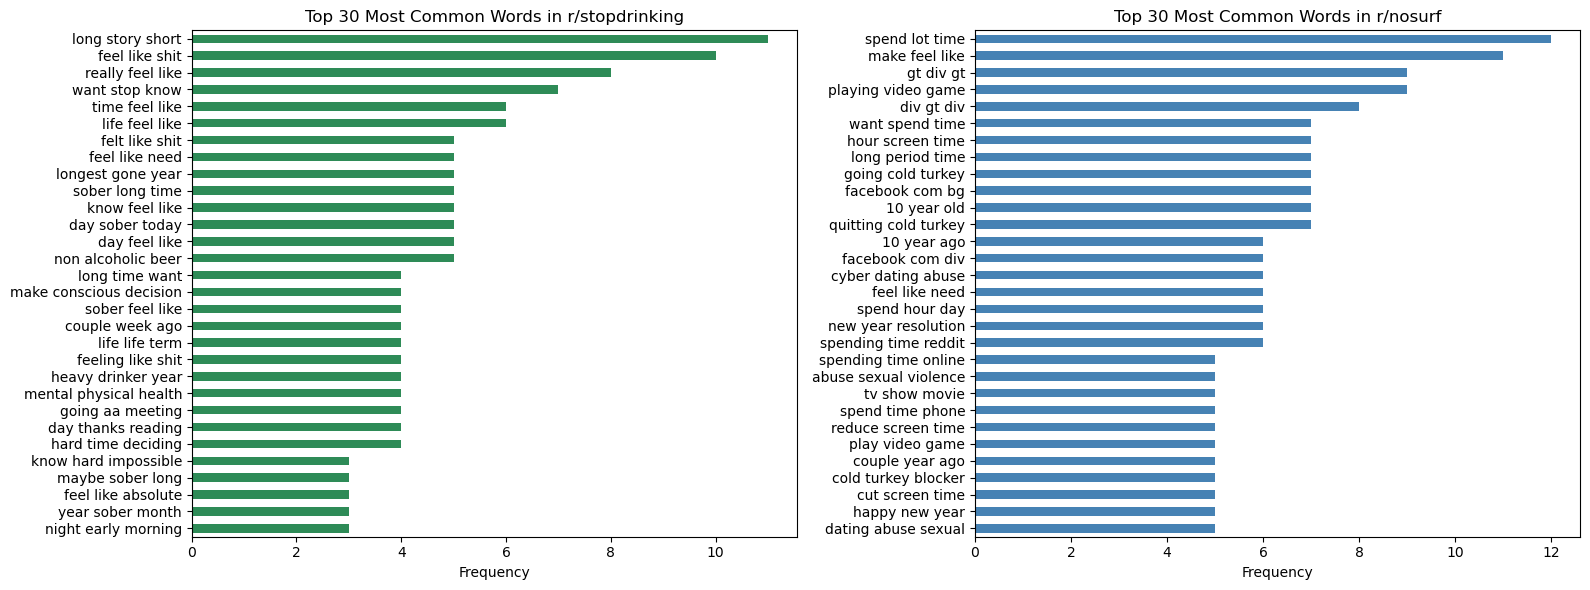

In [23]:
top_n_words(alcohol_text, internet_text, 'r/stopdrinking', 'r/nosurf', 3, 30)

Analysis of top three-word phrases:
- Emotions and time are again frequent topics
- Sexual abuse appear for Internet addiction

In all 6 lists, there are not too many unnecessary or meaningless words which has not been preprocessed earlier. This is as expected since 2 sets of stop_word lists were used during preprocessing. There is no need for further manual processing unless these show to affect the modelling later.

---
## Modelling
---

We will compare models using different vectorizers (Count Vectorizer and TFID Vectorizer) and classifier techniques (Logistic Regression and Multinomial Naive Bayes).

`r/nosurf` to be 1 and `r/stopdrinking` to be 0, thus False Negative would be `r/nosurf` wrongly classified as `r/stopdrinking` and the reverse for False Positive. As the chatbot is designed to provide advice based on whether the uses' questions relates to internet or alcohol addiction, there is equal significance in reducing the number of False Negatives and False Positives. Performance will be evaluated solely on *accuracy* (proportion of correctly predicted instances in the entire dataset).

Since both classes are have equal count, the baseline accuracy is around 50%. However, for the chatbot experience to be friendly, we hope to get an accuracy of 90% or higher.

In [24]:
# Split data into training and testing sets
X = df['text_cleaned'].tolist()
y = df['subreddit'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

**Select model and parameters**

In [25]:
# Function to find best hyperparameters for each model, and to compare each model result
def evaluate_models(models):
    results = ''
    best_est = []
    for model in models:
        vectorizer = model['vectorizer']
        classifier = model['classifier']
        params = model['params']
        
        # Create pipeline
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        
        # Gridsearch
        grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1) # 5 folds CV, use all processors
        grid_search.fit(X_train, y_train)

        # Score
        train_score = grid_search.score(X_train, y_train)
        test_score = grid_search.score(X_test, y_test)

        # Get confusion matrix values
        preds = grid_search.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        
        # Store best estimator
        best_est.append(grid_search.best_estimator_)      

        # Store results
        results += f"{model['name']}:\n"
        results += f"Best Cross Val Params: {grid_search.best_params_}\n"
        results += f"Best Cross Val Score: {round(grid_search.best_score_, 3)}\n"
        results += f"Train Score: {round(train_score, 3)}\n"
        results += f"Test Score: {round(test_score, 3)} | TN: {tn} | FP: {fp} | FN: {fn} | TP: {tp}\n"
        results += f"Overfitted (test minus train): {round(test_score - train_score, 3)}\n\n"
        
    return results, best_est

**Models 1 to 4: Logistic Regression vs Multinomial Naive Bayes**

In [26]:
# Define hyperparameters
classifier_nb_params = {
    'classifier__alpha': [0.1, 0.5, 1], # smoothing parameter; larger values means more smoothing
}

classifier_lr_params = {
    'classifier__C': [0.1, 1, 10], # inverse of regularization strength; smaller values specify stronger regularization
}

vectorizer_params = {
    'vectorizer__max_features': [1_000, 2_000, 3_000, 4_000], # only consider top max_features by term frequency
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], # lower and upper boundary of ngram range
    'vectorizer__min_df': [2, 3, 5], # ignore terms with document frequency < given threshold (counts)
    'vectorizer__max_df': [0.75, 0.80, 0.85], # ignore terms with document frequency > given threshold (proportion)
}


# Define models by vectorizer and classifier  
linear_models = [
    {'name': 'CountVectorizer with MultinomialNB', 
         'vectorizer': CountVectorizer(), 'classifier': MultinomialNB(), 
         'params': {**classifier_nb_params, **vectorizer_params}},
    
    {'name': 'TfidfVectorizer with MultinomialNB', 
         'vectorizer': TfidfVectorizer(), 'classifier': MultinomialNB(), 
         'params': {**classifier_nb_params, **vectorizer_params}},
    
    {'name': 'CountVectorizer with LogisticRegression', 
         'vectorizer': CountVectorizer(), 'classifier': LogisticRegression(), 
         'params': {**classifier_lr_params, **vectorizer_params}},
    
    {'name': 'TfidfVectorizer with LogisticRegression', 
         'vectorizer': TfidfVectorizer(), 'classifier': LogisticRegression(),
         'params': {**classifier_lr_params, **vectorizer_params}}
]

In [27]:
# Evaluate linear models
linear_compare_results, linear_best_est = evaluate_models(linear_models)
print(linear_compare_results)

CountVectorizer with MultinomialNB:
Best Cross Val Params: {'classifier__alpha': 0.5, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Best Cross Val Score: 0.957
Train Score: 0.963
Test Score: 0.944 | TN: 239 | FP: 11 | FN: 17 | TP: 232
Overfitted (test minus train): -0.019

TfidfVectorizer with MultinomialNB:
Best Cross Val Params: {'classifier__alpha': 0.5, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 3)}
Best Cross Val Score: 0.956
Train Score: 0.976
Test Score: 0.936 | TN: 235 | FP: 15 | FN: 17 | TP: 232
Overfitted (test minus train): -0.04

CountVectorizer with LogisticRegression:
Best Cross Val Params: {'classifier__C': 0.1, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 3000, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1)}
Best Cross Val Score: 0.938
Train Score: 0.981
Test Score: 0.934 | TN: 232 | FP: 18 | FN: 15

Generally all models work well with test accuracy scores above 0.93. The two Multinomial Naive Bayes models work better than the two Logistic Regressions models for this set.

*CountVectorizer with MultinomialNB* produces the best cross validation and test accuracy score. It has the highest percentage of True results and lowest percentage of False results. There is also the least overfitting with a difference of only 0.019 between train and test accuracy scores. The main area this model outperforms the other models is in having less False Positives (classifying `r/stopdrinking` wrongly as `r/nosurf`).

For all 4 models, there is little overfitting. Difference in train and test scores ranges between 0.019 and 0.055. Regularization for both MultinomialNB models is moderate, with alpha = 0.5. Regularization for LogisticRegression with TF-IDF Vectorizer is also moderate, with C of 1. Regularization for LogisticRegression with Count Vectorizer is higher, with value of 0.1. As there is little overfitting, we will not consider refining the tuning further.

Vectorizer parameters seem to be optimised, with MultinomialNB using bigram or trigram and Logistic Regression using unigram. Optimum phrase frequency ranges between 2,000 to 3,000 depending on model. Minimum frequency (min_df) varies across models while maximum frequency (max_df) at the threshold options does not seem to matter.

Including obvious phrases ('alcohol', 'internet' etc) could improve the accuracy of these models further. However to understand how well these models work, we exclude these obvious phrases.

**Models 5 to 6: Random Forest**

In [32]:
classifier_rf_params = {
    'classifier__n_estimators': [100, 150, 200], # number of trees in the forest
    'classifier__max_depth': [7, 9, 11] # maximum depth of the tree
}

rf_models = [
    {'name': 'CountVectorizer with RandomForest', 
         'vectorizer': CountVectorizer(), 'classifier': RandomForestClassifier(random_state=42), 
         'params': {**classifier_rf_params, **vectorizer_params}},
    
    {'name': 'TfidfVectorizer with RandomForest', 
         'vectorizer': TfidfVectorizer(), 'classifier': RandomForestClassifier(random_state=42), 
         'params': {**classifier_rf_params, **vectorizer_params}}
]

In [33]:
# Evaluate random forest model
rf_compare_results, rf_best_est = evaluate_models(rf_models)
print(rf_compare_results)

CountVectorizer with RandomForest:
Best Cross Val Params: {'classifier__max_depth': 9, 'classifier__n_estimators': 150, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 4000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}
Best Cross Val Score: 0.943
Train Score: 0.959
Test Score: 0.924 | TN: 243 | FP: 7 | FN: 31 | TP: 218
Overfitted (test minus train): -0.035

TfidfVectorizer with RandomForest:
Best Cross Val Params: {'classifier__max_depth': 11, 'classifier__n_estimators': 150, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 3000, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2)}
Best Cross Val Score: 0.941
Train Score: 0.965
Test Score: 0.94 | TN: 232 | FP: 18 | FN: 12 | TP: 237
Overfitted (test minus train): -0.025




The Random Forest with TF-IDF Vectorizer performed relatively well, while Random Forest with Count Vectorizer performed the worst in terms of Accuracy. It has the most False Negatives. 

The time taken to run is longer compared to the earlier linear models.

**Models 7 to 8: Gradient Boosting**

In [34]:
classifier_gb_params = {
    "classifier__max_depth": [3, 4], # maximum depth of the tree
    "classifier__n_estimators": [100, 125, 150], # number of trees in the forest
    "classifier__learning_rate": [0.10, 0.12, 0.14] # shrinks the contribution of each tree by learning_rate
}


gb_models = [
    {'name': 'CountVectorizer with GradientBoosting', 
         'vectorizer': CountVectorizer(), 'classifier': GradientBoostingClassifier(random_state=42), 
         'params': {**classifier_gb_params, **vectorizer_params}},
    
    {'name': 'TfidfVectorizer with GradientBoosting', 
         'vectorizer': TfidfVectorizer(), 'classifier': GradientBoostingClassifier(random_state=42), 
         'params': {**classifier_gb_params, **vectorizer_params}}
]

In [35]:
# Evaluate gradient boosting model
gb_compare_results, gb_best_est = evaluate_models(gb_models)
print(gb_compare_results)

CountVectorizer with GradientBoosting:
Best Cross Val Params: {'classifier__learning_rate': 0.14, 'classifier__max_depth': 3, 'classifier__n_estimators': 150, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Best Cross Val Score: 0.933
Train Score: 0.977
Test Score: 0.92 | TN: 222 | FP: 28 | FN: 12 | TP: 237
Overfitted (test minus train): -0.057

TfidfVectorizer with GradientBoosting:
Best Cross Val Params: {'classifier__learning_rate': 0.14, 'classifier__max_depth': 3, 'classifier__n_estimators': 150, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 4000, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2)}
Best Cross Val Score: 0.919
Train Score: 0.997
Test Score: 0.918 | TN: 221 | FP: 29 | FN: 12 | TP: 237
Overfitted (test minus train): -0.079




Gradient boosting performed the worst comparatively. Training set accuracy is the highest but testing set accuracy is the lowest. There is more overfitting compared to other models.

The time taken to run is longer compared to the earlier linear models.

**Summary of results**

|Model|Classifier|Vectorizer|Accuracy (CV)|Accuracy (Train)|Accuracy (Test)|False Positive|False Negative|
|:---|:---|:---|:---|:---|:---|:---|:---|
|1|**Multinomial NB**|**Count Vectorizer**|0.957|0.963|**0.944**|11|17|
|2|Multinomial NB|TF-IDF Vectorizer|0.956|0.976|0.936|15|17|
|3|Logistic Regression|Count Vectorizer|0.938|0.981|0.934|18|15|
|4|Logistic Regression|TF-IDF Vectorizer|0.949|0.987|0.932|18|16|
|5|Random Forest|Count Vectorizer|0.943|0.959|0.924|7|31|
|6|Random Forest|TF-IDF Vectorizer|0.941|0.965|0.940|18|12|
|7|Gradient Boosting|Count Vectorizer|0.933|0.977|0.920|28|12|
|8|Gradient Boosting|TF-IDF Vectorizer|0.919|0.997|0.918|29|12|

Count Vectorizer with Multinomial Naive Bayes (Model 1) has the best accuracy. It also runs faster than the Ensemble models. This model was chosen.

### Model Selected: CountVectorizer with Multinomial Naive Bayes

In [36]:
# Select 1st model from linear
selected_est = linear_best_est[0]
selected_est

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.75, max_features=2000, min_df=3,
                                 ngram_range=(1, 2))),
                ('classifier', MultinomialNB(alpha=0.5))])

In [37]:
# Function to output various analysis based on selected model with given best parameters
def selected_model_input(output):
    # Fit the model and get predictions
    pipeline_1 = selected_est
    pipeline_1.fit(X_train, y_train)
    preds = pipeline_1.predict(X_test)

    # Calculate scores
    train_score = pipeline_1.score(X_train, y_train)
    test_score = pipeline_1.score(X_test, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    if output == 'score':
        print(f"Train Score: {round(train_score, 3)}")
        print(f"Test Score: {round(test_score, 3)} | TN: {tn} | FP: {fp} | FN: {fn} | TP: {tp}\n")        
    
    elif output == 'confusion_matrix':
        # Plot confusion matrix
        cm = confusion_matrix(y_test, preds)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(cmap='Reds');
        
    elif output == 'coeff_chart':
        # Get feature names from vectorizer
        feature_names = pipeline_1.named_steps['vectorizer'].get_feature_names_out()

        # Get feature log probabilities for positive and negative class from classifier
        neg_log_probs = pipeline_1.named_steps['classifier'].feature_log_prob_[0]
        pos_log_probs = pipeline_1.named_steps['classifier'].feature_log_prob_[1]

        # Compute difference in log probabilities in the positive and negative class
        delta_log_prob = pos_log_probs - neg_log_probs

        # Create result dataframe
        result_df = pd.DataFrame({'feature': feature_names, 'coef': delta_log_prob})
        result_df = result_df.sort_values(by='coef', ascending=False)

        # Plot top 20 positive and top 20 negative coefficients
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
        result_df.tail(20).plot.barh(x='feature', y='coef', ax=ax1, color='seagreen', legend=False)
        result_df.head(20)[::-1].plot.barh(x='feature', y='coef', ax=ax2, color='steelblue', legend=False)
        ax1.set_title('Top 20 Coefficients for r/stopdrinking')
        ax2.set_title('Top 20 Coefficients for r/nosurf')

        plt.tight_layout();
    
    elif output == 'false_list':
        # Set option to display the full width of text columns without truncation
        pd.set_option('display.max_colwidth', None)

        # Creates DataFrame with the actual test values and the predicted values; concat with test data
        df_actual_pred = pd.DataFrame()
        df_actual_pred['actual'] = y_test
        df_actual_pred['predicted'] = preds
        df_classify = pd.concat([pd.DataFrame(X_test, columns=['text_cleaned']), df_actual_pred], axis=1)
        
        # Filters rows of the DataFrame to only keep misclassified examples
        classify_wrong = df_classify[df_classify['predicted'] != df_classify['actual']]
        classify_wrong.reset_index(drop=True, inplace=True)
        
        # List false negatives in DataFrame   
        false_negatives = pd.DataFrame(classify_wrong[classify_wrong['predicted'] == 0]['text_cleaned'])
        false_negatives.columns = ['False Negative: r/nosurf wrongly classified as r/stopdrinking']

        # List false positives in DataFrame        
        false_positives = pd.DataFrame(classify_wrong[classify_wrong['predicted'] == 1]['text_cleaned'])
        false_positives.columns = ['False Positive: r/stopdrinking wrongly classified as r/nosurf']

        display(false_negatives)
        display(false_positives)

In [38]:
# Print scores
selected_model_input('score')

Train Score: 0.963
Test Score: 0.944 | TN: 239 | FP: 11 | FN: 17 | TP: 232



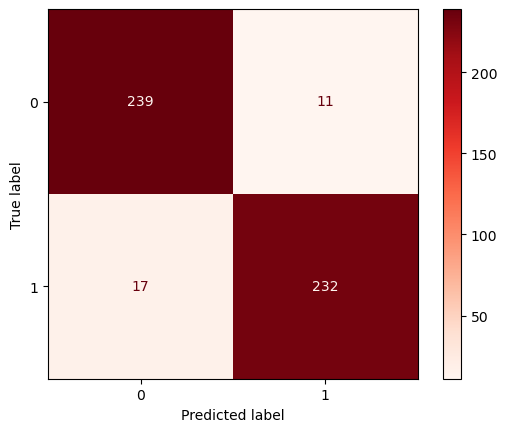

In [39]:
# Plot confusion matrix
selected_model_input('confusion_matrix')

There were only 17 false negative (wrongly classified as r/stopdrinking) and 11 false positive cases (wrongly classified as r/nosurf).

**Feature importance**

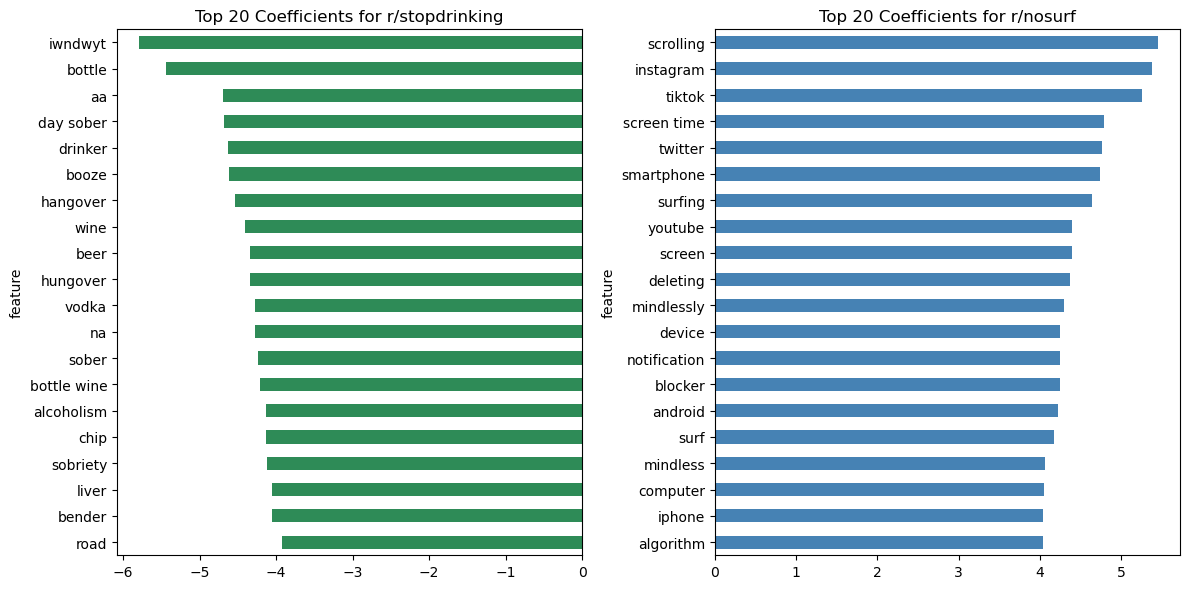

In [40]:
# Plot chart of top coefficients
selected_model_input('coeff_chart')

Top 20 Coefficients for `r/stopdrinking`: <br>
- top result is 'iwndwyt' which stands for ['I Will Not Drink With You Today'](https://iwndwyt.app/), a phrase common on social media which signals to other users that they are not alone and there are others out there going through similar battles with alcohol.
- 'aa' stands for [Alcoholics Anonymous](https://www.aa.org/what-is-aa), a fellowship of people who come together to solve their drinking problem
- 'na' refers to non-alcoholic drinks
- types of drinks are common within the list: bottle, wine, beer, vodka, booze etc
- state of being drunk is common within the list: sober, hangover etc

Top 20 Coefficients for `r/nosurf`: <br>
- medium of addiction are common within the list: instagram, tiktok, twitter, smartphone, youtube, screen, device etc
- related actions are common within the list: scrolling, surfing, deleting
- means to change habits are found within the list: notification, blocker

The models could work well because there are sufficient differences in key words and phrases used in both topics, and because adequate preprocessing is done to remove noises which do not make sense.

There are no abnormal phrases within the Top 20 Coefficients. Since obvious phrases (alcohol, internet etc) are removed during preprocessing, they are not found within these lists.

**Error analysis on selected model**

In [41]:
# Display false negative and false positive lists
selected_model_input('false_list')

,False Negative: r/nosurf wrongly classified as r/stopdrinking
0,heard subreddit 3yrs ago gotten worse subreddit 13 16 unhappy 13 2020 covid hit allowed outside dependency worse maladaptive daydream entire day habit followed day went puberty body young woman hate wish wish went guy puberty instead knew 11 adult listen going therapy know mother want fucking slow time slow 17th birthday april basically year couple month try reap effect starting puberty wish let started therapy 12 instead telling fuck brought effecting outside gym quit use equipment home worried staring obviously girl pretending guy force stand straight 1 hurt 2 push tit probably hunch place thing wanna active winter shit apparently icy punching bag really bicycle broke winter point taking shop fixed actually 2 need replace brake lever one new bike super small lose know like learn course shop course course near live em ffs kinda ranting feel like wasted life let honest live guy soon really making 25 21 matter probably day blended change hate teenage year supposed fun miserable gotta worn rest life like travel vanlife idk possible suppose bike camping stuff mind worried hate winter unlike autumn outside anymore shitty exciting outside
2,day 0 start journey hardcore
4,pushed self reflect reading dale wimbrow guy glass come inspirational quote picture give extra push day come truly help reshape view life thing dale wimbrow poem guy glass poem meant remind opinion truly count end day meet standard approve ourself sleep better little better night like feel like struggle self awareness self love check guy glass break favorite poem talk commendation criticism verdict count person standing reflection
6,think past stay
8,cancer friend medical leave work guy kill time b c tired reading walking lol life get really repetitive know anymore chemo isolation make thing worse lol
9,year left live stop start care care thought feeling action different gave time live heard question podcast recently thought community appreciate question bring ahas realisation
10,lost loner
11,lasted 3 day disappointed failed pressure logged reddit yesterday 3rd fight wife resolution better communication said fuck gave going end binge today horse
12,easier title say
13,test testicle


,False Positive: r/stopdrinking wrongly classified as r/nosurf
1,liar check henry rollins music video liar remind believe nice thing trying tell link video link allowed
3,using nomo sobriety day counting app installed nomo night free actually used kind addiction cessation feature counter wondered used
5,stop life spiraling downward help appreciated
7,giving try need
15,tried people like seizure withdrawal word fallen short song perfectly portrays experience like use reminder hell
16,trying non related social activity want bar person life half fun suck concept want activity involve problem free time revolves nightlife show involve certain intoxication head easy switching day time activity maybe join sport saying easier
18,brain mush hate
19,half year working day watching eat progress pic included august 2022 decided stop improved aspect life literally happier relationship better feel great lifelong dream given actually started coming true easy recommend stopping diet exercise wise apps like adapt exercise food data customizable actually sustainable diet counting macro avatar nutrition app exercise weightlifting fitbod app running listening podcasts 1 2 hour day pic thanks community supportive lurker let know question
20,new account post day need help
25,lori gottlieb quote insight booby prize therapy favorite maxim trade meaning insight world change world insight therapy worthless insight allows ask answer give choice make pumped platitude bit wisdom step door sunlight everyday world kind post nut clarity hit euphoria recent epiphany turn vapor learned quote testifies fact actually roll sleeve work adopting new insight easier said sunlight everyday world hit project today actively practice man want real world


Extracted the processed text of false results to analyse if it is due to modelling fault. Among the false positives, ['doomscrolling'](https://www.health.com/mind-body/what-is-doomscrolling) should have been picked up to classify the text as belonging to `r/nosurf` and 'sobriety' should have been picked up to classify the text as belonging to `r/stopdrinking`.  

In most other cases above, it is due to text not having sufficient relevant words or phrases to classify correctly (e.g. 'think past say'). In some cases, there could be misleading words (e.g. 'video' seems more related to internet than alcohol, resulting in misclassification). Another possibility is that removing the obvious words (e.g. 'alcohol', 'internet') resulted in some of these text not having sufficient relevant words or phrases to classify correctly.

In short, besides one or two cases, false results are not due to modelling fault but the input text. The model is sufficiently robust and there is not much that can be done to improve the model accuracy.

---
## Conclusion and Recommendations
---

**Conclusion and Recommendations**

The selected model, Count Vectorizer with Multinomial Naive Bayes, has high accuracy of 0.944. Besides one or two cases, those False results are mostly due to input issues and not the model issue. The accuracy should improve even further if it includes the obvious phrases which were excluded for this project. As such the model is well suited for the chatbot.

In addition, although higher accuracy means better user experience, it is not critical (and practical) for the chatbot to be fully accurate. The chatbot should be designed to consider such cases. For example, misclassification can be rectified through clarification by chatbot user that he/she has been assigned wrongly. The chatbot can then route the user to the correct set of advice and recommendations.

Preprocessing was mostly automated. Most stopwords were removed using available stopword sets and there was minimal manual removal of stopwords. This means that there should be minimal maintenance efforts (e.g. modifying/adding new stopwords) after implementation.

The top coefficients of the selected model highlights common phrases. These relate mostly to medium, actions and ways to curb the habits among others. It also highlights some phrases we may not expect or familiar with, but are commonly used in these topics (e.g. 'iwndwyt', 'NA').

**Possible improvements**
- More data to improve score further
- Multiple sources besides Reddit for better reflection of words to be trained
- Finetuning of hyperparameters, especially for ensemble models to improve performance and/or reduce overfitting. However, this requires more time or resources
- Extend to other types of addictions or more targeted advice based on needs (e.g. for community or emotional support, or to get tips etc)